In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error

from matplotlib import ticker
import matplotlib.pyplot as plt

In [4]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.7 MB/s eta 0:00:00


In [65]:
df = pd.read_csv('/content/ACB.VN.csv')

In [27]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,8533.238281,8619.142578,8447.333008,8590.507813,8254.484375,5164405.0
1,2019-03-04,8590.507813,8733.682617,8561.873047,8705.047852,8364.543945,10898750.0
2,2019-03-05,8705.047852,8790.953125,8619.142578,8676.413086,8337.029297,8611453.0
3,2019-03-06,8647.778320,8705.047852,8590.507813,8676.413086,8337.029297,11100248.0
4,2019-03-07,8705.047852,8790.953125,8676.413086,8733.682617,8392.058594,11530669.0
5,2019-03-08,8705.047852,8762.318359,8647.778320,8676.413086,8337.029297,4948093.0
6,2019-03-11,8676.413086,8762.318359,8647.778320,8705.047852,8364.543945,9866759.0
7,2019-03-12,8733.682617,8848.223633,8676.413086,8848.223633,8502.119141,8745639.0
8,2019-03-13,8905.493164,9077.303711,8848.223633,8991.398438,8639.694336,19114578.0
9,2019-03-14,8991.398438,9163.208008,8962.763672,9020.033203,8667.208984,8148129.0


In [66]:
# Preprocess data
# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [68]:
df = df.dropna() # Drop missing values

In [69]:
df

,Close
Date,
2019-03-01,8590.507813
2019-03-04,8705.047852
2019-03-05,8676.413086
2019-03-06,8676.413086
2019-03-07,8733.682617
...,...
2024-03-04,24173.912109
2024-03-05,24304.347656
2024-03-06,24000.000000


In [70]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(df))

In [71]:
# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

In [72]:
train_data = df[:train_size]
test_data = df[train_size:]

In [73]:
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [76]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(model.summary())

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14276.117, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14272.113, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14274.113, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14274.120, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14271.268, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.609 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1001
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7134.634
Date:                Sat, 15 Jun 2024   AIC                          14271.268
Time:                        08:50:54   BIC                          14276.175
Sample:                             0   HQIC                         14273.133
                               - 1001                                  

In [77]:
order = (model.order[0], model.order[1], model.order[2])
print(order)

(0, 1, 0)


In [78]:
from statsmodels.tsa.arima.model import ARIMA
def evaluate_ariama_model(x_data, y_data, order):
    y_pred = list()
    history = [x for x in y_train]
    for t in range(len(y_data)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        y_pred.append(yhat)
        obs = y_data[t]
        history.append(obs)
    mse = mean_squared_error(y_data, y_pred)
    mae = mean_absolute_error(y_data, y_pred)
    mape = mean_absolute_percentage_error(y_data, y_pred)
    rmse = mean_squared_error(y_data, y_pred, squared=False)
    return y_pred, mse, mae, mape, rmse

In [79]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred, test_mse, test_mae, test_mape, test_rmse = evaluate_ariama_model(x_test, y_test, order)

print("Price predict on test data:", y_pred)
print("MSE on test data:", test_mse)
print("MAE on test data:", test_mae)
print("MAPE on test data:", test_mape)
print("RMSE on test data:", test_rmse)

Price predict on test data: [18903.591797, 19168.242188, 18827.976563, 18525.519531, 18185.255859, 18752.363281, 18449.90625, 18412.097656, 18147.447266, 18298.675781, 18260.869141, 18525.519531, 18563.326172, 18487.712891, 18487.712891, 18449.90625, 18601.134766, 18903.591797, 19092.626953, 19017.013672, 19130.435547, 18827.976563, 18941.398438, 18903.591797, 18865.785156, 18790.169922, 18865.785156, 18865.785156, 18903.591797, 18714.556641, 18449.90625, 18336.484375, 18336.484375, 18298.675781, 18260.869141, 18260.869141, 18260.869141, 18298.675781, 18676.748047, 18638.941406, 18865.785156, 18827.976563, 18827.976563, 18827.976563, 18903.591797, 18903.591797, 18903.591797, 18827.976563, 18903.591797, 18865.785156, 18941.398438, 19168.242188, 19017.013672, 18979.205078, 18903.591797, 19017.013672, 19054.820313, 19206.048828, 18608.695313, 18956.521484, 18913.042969, 18956.521484, 19000.0, 18782.609375, 18739.130859, 18652.173828, 18782.609375, 18826.087891, 18869.564453, 18956.521484,

In [51]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.061800630250994165
RMSE on Test dataset:  37628765.20310442
MSLE on Test dataset:  0.010335838027662579


In [81]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')


# Create arrays of consecutive integers for the next 30, 60, and 90 days
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# Predict the closing prices for the next 30 days
y_next_30_days = list()
history = [x for x in y_test]
for t in range(len(x_next_30_days)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    y_next_30_days.append(yhat)
    obs = y_test[t]
    history.append(obs)

y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))

# Use the predictions of the first 30 days to predict the next 30 days
x_next_60_days = np.array(range(last_index + 31, last_index + 61)).reshape(-1, 1)
# Predict the closing prices for the next 60 days
y_next_60_days = list()
history = [x for x in y_test]
for t in range(len(x_next_60_days)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    y_next_60_days.append(yhat)
    obs = y_test[t]
    history.append(obs)
y_next_60_days = scaler.inverse_transform(np.array([y_next_60_days]).reshape(-1, 1))

# Use the predictions of the first 60 days to predict the next 30 days
x_next_90_days = np.array(range(last_index + 61, last_index + 91)).reshape(-1, 1)
# Predict the closing prices for the next 90 days
y_next_90_days = list()
history = [x for x in y_test]
for t in range(len(x_next_90_days)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    y_next_90_days.append(yhat)
    obs = y_test[t]
    history.append(obs)
y_next_90_days = scaler.inverse_transform(np.array([y_next_90_days]).reshape(-1, 1))


In [92]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=90, freq='D')  # Extended for 90 days

# Create arrays for 30, 60, and 90 days
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)

# Predict for the next 30 days
y_next_30_days = list()
history = [x for x in y_test]
for t in range(len(x_next_30_days)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    y_next_30_days.append(yhat)
    history.append(yhat)

# Predict for the next 60 days (building on the 30-day predictions)
y_next_60_days = list()
history = y_next_30_days.copy()  # Start with the 30-day predictions
for t in range(len(x_next_60_days)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    y_next_60_days.append(yhat)
    history.append(yhat)

# Predict for the next 90 days (building on the 60-day predictions)
y_next_90_days = list()
history = y_next_60_days.copy()  # Start with the 60-day predictions
for t in range(len(x_next_90_days)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    y_next_90_days.append(yhat)
    history.append(yhat)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

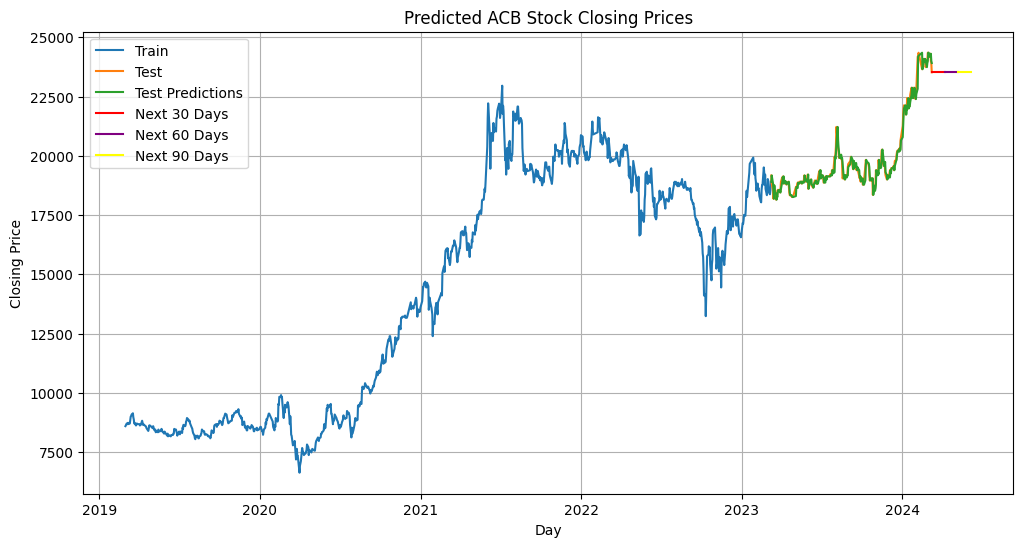

In [96]:
plt.figure(figsize=(12,6))

# Plot the train, test, and validation data
plt.plot(train_data.index, train_data['Close'], label='Train')
plt.plot(test_data.index, test_data['Close'], label='Test')

# Plot the predictions for test and validation sets
plt.plot(test_data.index, y_pred, label='Test Predictions')

# Plot the predictions for the next 30, 60, and 90 days
date_range_30 = date_range[:30]
date_range_60 = date_range[30:60]
date_range_90 = date_range[60:]
plt.plot(date_range_30, y_next_30_days, color='red', label='Next 30 Days')
plt.plot(date_range_60, y_next_60_days, color='purple', label='Next 60 Days')
plt.plot(date_range_90, y_next_90_days, color='yellow', label='Next 90 Days')

# Adding titles and labels
plt.title('Predicted ACB Stock Closing Prices')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()